In [20]:
import os

import tensorflow as tf
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TF: 2.21.0-dev20251017
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#imports
import numpy as np
import pandas as pd
import os 
from PIL import Image
import matplotlib.pyplot as plt

import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import MaxPooling2D,Conv2D,Dense,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [ ]:
#directories
base_dir = '' 
train_dir = os.path.join(base_dir,'/home/lurpd/Development/Datasets/DistractedDriverSet/imgs/train/') 

In [ ]:
#add random letterboxing to trainng 
import numpy as np
from PIL import Image

def random_letterbox(img_array):
    if img_array.ndim == 3 and img_array.shape[-1] == 1:
        img_array = np.squeeze(img_array, axis=-1)

    img = Image.fromarray(np.uint8(img_array))
    target_size = (128, 128)
    
    scale = np.random.uniform(0.8, 1.0)
    
    new_w = int(target_size[0] * scale)
    new_h = int(target_size[1] * scale)
    
    img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)
    
    background = Image.new("L", target_size, 0)
    
    x_offset = (target_size[0] - new_w) // 2
    y_offset = (target_size[1] - new_h) // 2
    
    background.paste(img, (x_offset, y_offset))
    
    arr = np.array(background).astype(np.float32)
    arr = np.expand_dims(arr, axis=-1)
    return arr 


In [ ]:
image_size = (128,128)
batch_size = 64
val_size = 0.2

#random data changes for better generalizing
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=random_letterbox,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True
)

val_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

#training params
train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size = image_size,
    batch_size = batch_size,
    seed=42, 
    shuffle=True,
    subset='training',
    color_mode='grayscale'
)

val_generator = val_data_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    subset='validation',
    color_mode='grayscale',
    class_mode='categorical',
)


In [ ]:
#debug count data
import collections

class_counts = collections.Counter(train_generator.classes)
for cls, count in class_counts.items():
    print(f"{cls} ({list(train_generator.class_indices.keys())[cls]}): {count}")

0 (c0): 7446
1 (c1): 21828
2 (c2): 2162


(64, 128, 128, 1)
(64, 3)
(64, 128, 128, 1) 0.0 1.0


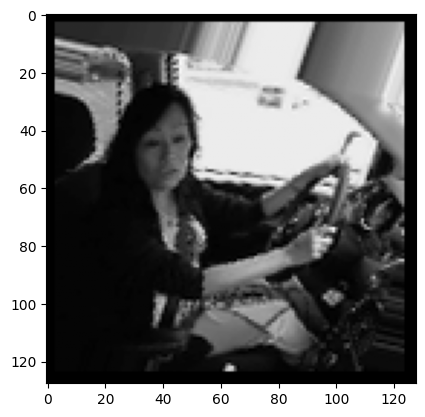

In [ ]:
for data_batch,label_batch in train_generator:
    print(data_batch.shape) 
    print(label_batch.shape) 
    break

batch_x, batch_y = next(train_generator)
print(batch_x.shape, batch_x.min(), batch_x.max())
plt.imshow(batch_x[0].squeeze(), cmap='gray')
plt.show()

In [ ]:
#cpu handle random dropout cuz issue with CUDA
import tensorflow as tf
from keras.layers import Dropout

class CPUDropout(Dropout):
    def call(self, inputs, training=None):
        with tf.device('/CPU:0'):
            return super().call(inputs, training=training)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Conv2D
from tensorflow.keras.models import Model
import tensorflow as tf

#convert grayscale
def to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

#use mobilenet for base model since my own model lowk tweakn
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  #freeze feature extractor initially

#custom classifier
inputs = Input(shape=(128, 128, 1))
x = tf.keras.layers.Lambda(to_rgb)(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

#yay
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,715 (9.87 MB)

 Trainable params: 329,219 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [32]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#autocalculate class weight
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_indices = train_generator.class_indices
num_classes = len(class_indices)
class_labels = np.unique(train_generator.classes)

weights = compute_class_weight(
    class_weight="balanced",
    classes=class_labels,
    y=train_generator.classes
)

class_weights = dict(enumerate(weights))

print("\nAuto-calculated class weights:")
for i, w in class_weights.items():
    class_name = list(class_indices.keys())[i]
    print(f"  {i} ({class_name}): {w:.3f}")

# manual weights just in case
# class_weights = {
#     0: 1.2,  #Safe driving
#     1: 0.7,  #distracted
#     2: 0.1,  #tired
# }


Image count per class:
  0 (c0): 7446 images
  1 (c1): 21828 images
  2 (c2): 2162 images

Auto-calculated class weights:
  0 (c0): 1.407
  1 (c1): 0.480
  2 (c2): 4.847


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#stop training if too much loss or plateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

steps_per_epoch = len(train_generator) 
validation_steps = len(val_generator)  

#start training
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/10


/home/lurpd/Development/DistractionAI/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1761118031.921029   82115 assert_op.cc:39] Ignoring Assert operator functional_18_1/lambda_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1761118031.922467   82115 assert_op.cc:39] Ignoring Assert operator functional_18_1/lambda_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


454/492 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.4945 - loss: 1.2072

W0000 00:00:1761118082.042979   82118 assert_op.cc:39] Ignoring Assert operator functional_18_1/lambda_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1761118082.043255   82118 assert_op.cc:39] Ignoring Assert operator functional_18_1/lambda_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5011 - loss: 1.1883

W0000 00:00:1761118092.392301   82114 assert_op.cc:39] Ignoring Assert operator functional_18_1/lambda_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1761118092.393553   82114 assert_op.cc:39] Ignoring Assert operator functional_18_1/lambda_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
W0000 00:00:1761118100.696753   82116 assert_op.cc:39] Ignoring Assert operator functional_18_1/lambda_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1761118100.696861   82116 assert_op.cc:39] Ignoring Assert operator functional_18_1/lambda_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


492/492 ━━━━━━━━━━━━━━━━━━━━ 77s 137ms/step - accuracy: 0.5832 - loss: 0.9557 - val_accuracy: 0.5330 - val_loss: 2.6054 - learning_rate: 1.0000e-04
Epoch 2/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.7199 - loss: 0.6494 - val_accuracy: 0.6174 - val_loss: 2.3752 - learning_rate: 1.0000e-04
Epoch 3/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.7688 - loss: 0.5565 - val_accuracy: 0.6079 - val_loss: 2.3919 - learning_rate: 1.0000e-04
Epoch 4/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.7864 - loss: 0.5148 - val_accuracy: 0.6312 - val_loss: 2.3116 - learning_rate: 1.0000e-04
Epoch 5/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 52s 106ms/step - accuracy: 0.8026 - loss: 0.4781 - val_accuracy: 0.6278 - val_loss: 2.2790 - learning_rate: 1.0000e-04
Epoch 6/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 53s 107ms/step - accuracy: 0.8152 - loss: 0.4527 - val_accuracy: 0.6426 - val_loss: 2.0193 - learning_rate: 1.0000e-04
Epoch 7/10
492/492 ━━━━━━━━━━━━━━━━━━━━ 52s 106ms/step - 

In [35]:
model.save("distracted_driver_detection.keras")

In [36]:
tr_loss = history.history['loss']
tr_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

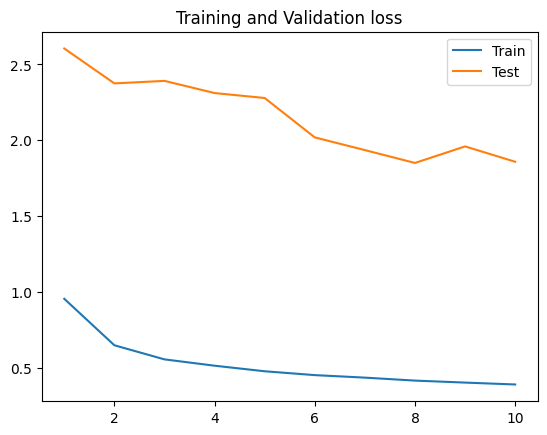

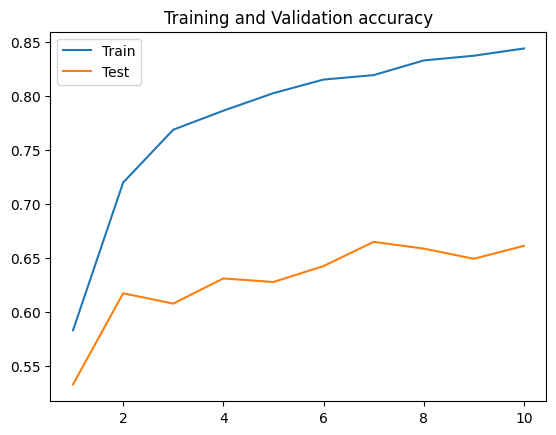

In [ ]:
#graph training results
epchs = list(range(1,len(tr_loss)+1))
plt.plot(epchs,tr_loss,label='Train')
plt.plot(epchs,val_loss,label='Test')
plt.title("Training and Validation loss")
plt.legend()
plt.show()


plt.plot(epchs,tr_accuracy,label='Train')
plt.plot(epchs,val_accuracy,label='Test')
plt.title("Training and Validation accuracy")
plt.legend()
plt.show()

In [ ]:
# test model with real data and show results
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import os
import math

def to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

model = load_model("distracted_driver_detection.keras",
    custom_objects={
        "CPUDropout": Dropout,
        "to_rgb": to_rgb
    })

class_names = ["Safe driving", "Distracted", "Tired"]

folder = "/home/lurpd/Development/Datasets/MyData/"
target_size = (128, 128)

image_paths = []
for i in range(30, 63):
    for ext in [".png", ".PNG", ".jpg", ".JPG", ".jpeg", ".JPEG"]:
        candidate = os.path.join(folder, f"{i}{ext}")
        if os.path.exists(candidate):
            image_paths.append(candidate)
            break  

cols = 8
rows = math.ceil(len(image_paths) / cols)
max_width_px = 2500
max_height_px = 1300
dpi = 100
fig_width = min(max_width_px / dpi, cols * 3)
fig_height = min(max_height_px / dpi, rows * 3)
plt.figure(figsize=(fig_width, fig_height), dpi=dpi)

for idx, img_path in enumerate(image_paths):
    img = Image.open(img_path).convert("L")
    img = ImageOps.pad(img, target_size, color=0, method=Image.Resampling.LANCZOS)
    img_array = np.expand_dims(np.array(img).astype(np.float32) / 255.0, axis=(0, -1))

    predictions = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_names[predicted_class]
    confidence = np.max(predictions) * 100

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.text(
        0.5, -0.05,
        f"{os.path.basename(img_path)}\n{predicted_label} ({confidence:.1f}%)",
        fontsize=9,
        ha="center", va="top",
        transform=plt.gca().transAxes
    )

plt.tight_layout()
plt.draw()

output_path = "predictions_grid.png"
plt.savefig(output_path, dpi=150, bbox_inches="tight")
print(f"Saved predictions grid to {output_path}")

try:
    if os.path.exists("/mnt/c/Windows"):
        os.system(f"explorer.exe {output_path.replace('/', '\\\\')}")
    else:
        os.system(f"xdg-open {output_path}")
except Exception as e:
    print(f"Could not auto-open image: {e}")


TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 4.999999873689376e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: <class 'keras.src.layers.core.lambda_layer.Lambda'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Lambda', 'config': {'name': 'lambda', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'function': {'module': 'builtins', 'class_name': 'function', 'config': 'to_rgb', 'registered_name': 'function'}, 'arguments': {}}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 1]}, 'name': 'lambda', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 1], 'dtype': 'float32', 'keras_history': ['input_layer_2', 0, 0]}}], 'kwargs': {'mask': None}}]}.

Exception encountered: Could not locate function 'to_rgb'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'to_rgb', 'registered_name': 'function'}